자신의 프로젝트명을 입력하세요.

In [1]:
Project = 'pipojsy'

작성한 코드로부터 hex 파일을 컴파일합니다.

In [2]:
%%bash
avr-gcc --version
arm-none-eabi-gcc --version

avr-gcc (GCC) 4.9.2
Copyright (C) 2014 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET = 'TINYAES128C'
FW_PATH = 'Base'

In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$FW_PATH"
cd $3
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-base-CW308_STM32F3.hex
rm -f -- simpleserial-base-CW308_STM32F3.eep
rm -f -- simpleserial-base-CW308_STM32F3.cof
rm -f -- simpleserial-base-CW308_STM32F3.elf
rm -f -- simpleserial-base-CW308_STM32F3.map
rm -f -- simpleserial-base-CW308_STM32F3.sym
rm -f -- simpleserial-base-CW308_STM32F3.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-base.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-base.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compi

Chipwhisperer에서 자신이 컴파일한 프로젝트가 작동하도록 올립니다.

In [5]:
import chipwhisperer as cw

# connect
scope = cw.scope()
target = cw.target(scope)

# setup
scope.gain.gain = 45
scope.adc.samples = 10000 # increase this to acquire much long trace
scope.adc.offset = 0
scope.adc.basic_mode = 'rising_edge'
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = 'clkgen_x4'
scope.trigger.triggers = 'tio4'
scope.io.tio1 = 'serial_rx'
scope.io.tio2 = 'serial_tx'
scope.io.hs2 = 'clkgen'

Serial baud rate = 38400


In [6]:
# make sure that the baud rate on target side in '*_hal.c', and scope side in 'serial.py' are same as 115200 or 38400
if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    target.baud = 38400
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    target.baud = 38400
    prog = cw.programmers.XMEGAProgrammer

fw_path = FW_PATH + '/simpleserial-base-%s.hex'%PLATFORM # check your binary file name
cw.program_target(scope, prog, fw_path)

Serial baud rate = 38400
Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6583 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6583 bytes
Serial baud rate = 38400


Trace 폴더에 trace 파일을 npy 형태로 저장합니다. 자료형은 float 으로 저장됩니다.

NUM_TRACES 인자에 수집할 파형 개수를 입력합니다.

In [7]:
NUM_TRACES = 5000

이제 chipwhisperer가 당신의 코드로부터 파형을 수집합니다.

In [8]:
from tqdm import tnrange
import numpy as np
import sys
# capture
ktp = cw.ktp.Basic()
traces = []
for i in tnrange(NUM_TRACES, desc = 'Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    traces.append(trace)

# convert
traces_array  = np.asarray([trace.wave for trace in traces])
textin_array  = np.asarray([trace.textin for trace in traces])
textout_array = np.asarray([trace.textout for trace in traces])
keylist_array = np.asarray([trace.key for trace in traces])

# save
from datetime import datetime
import os
now = datetime.now().strftime('%Y.%m.%d-%H.%M.%S')
os.mkdir(now)
np.save('%s/%s_traces'%(now, now), traces_array)
np.save('%s/%s_textin'%(now, now), textin_array)
np.save('%s/%s_textout'%(now, now), textout_array)
np.save('%s/%s_keylist'%(now, now), keylist_array)

/home/vagrant/.pyenv/versions/3.6.7/envs/cw/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


제대로 수집되었는지 5개만 확인해봅니다.

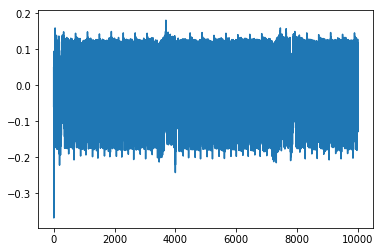

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

for i in range(1):
    plt.plot(traces_array[i])
plt.show()

작업이 종료되었으므로, 자신의 프로젝트와 chipwhisperer의 연결을 종료합니다.

다른 프로젝트와 충돌되는 현상을 막기 위해 필요합니다.

In [10]:
target.dis()
scope.dis()

npy로 되어있는 트레이스를 binary 형태로 변환합니다.

변환된 트레이스는 Trace 폴더에 trace.bin의 형태로 저장됩니다.

저장된 데이터는 4바이트 단위 바이너리로 구성됩니다.

In [11]:
import struct
import numpy as np
traces = np.load('%s/%s_traces.npy'%(now, now))
textin = np.load('%s/%s_textin.npy'%(now, now))

In [12]:
f=open("%s/trace.bin"%(now),"wb")
for i in range(len(traces)):
    myfmt='f'*len(traces[i]) 
    bin=struct.pack(myfmt,*traces[i])
    f.write(bin)
f.close()